In [29]:
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from scipy.stats import norm

import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
x_train[0].shape

(28, 28)

In [5]:
def preprocess(image):
    """Normalize the images"""
    image = image.astype('float32') / 255.0
    image = np.pad(image, ((0,0), (2,2), (2,2)), constant_values=0.0)
    image = np.expand_dims(image, -1)
    return image

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
IMAGE_SIZE = x_train[0].shape[0]

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,1), name="encoder_input")

In [9]:
x = layers.Conv2D(32, (3,3), strides = 2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
shape_before_flattening_1 = x.shape[1:]

In [10]:
x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [11]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [12]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="Same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides =2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (2,2), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [13]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [14]:
BETA = 500

In [15]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
        }


In [16]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [17]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [18]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=100,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 18s 21ms/step - total_loss: 163.1093 - reconstruction_loss: 158.7294 - kl_loss: 4.3801 - val_loss: 144.0745 - val_reconstruction_loss: 139.1657
Epoch 2/5
600/600 [==============================] - 12s 20ms/step - total_loss: 136.8607 - reconstruction_loss: 131.9184 - kl_loss: 4.9423 - val_loss: 139.3458 - val_reconstruction_loss: 134.1920
Epoch 3/5
600/600 [==============================] - 12s 21ms/step - total_loss: 134.5039 - reconstruction_loss: 129.4444 - kl_loss: 5.0595 - val_loss: 137.0158 - val_reconstruction_loss: 131.8441
Epoch 4/5
600/600 [==============================] - 12s 20ms/step - total_loss: 133.4538 - reconstruction_loss: 128.3158 - kl_loss: 5.1380 - val_loss: 136.0404 - val_reconstruction_loss: 130.7707
Epoch 5/5
600/600 [==============================] - 12s 21ms/step - total_loss: 132.7589 - reconstruction_loss: 127.5831 - kl_loss: 5.1757 - val_loss: 136.0683 - val_reconstruction_loss: 130.7373


In [19]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [20]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 4ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[7.69530743e-07],
         [4.38078480e-08],
         [1.31554259e-07],
         ...,
         [1.70016640e-10],
         [3.79371590e-10],
         [2.60538018e-05]],

        [[1.90823535e-08],
         [6.84568846e-10],
         [4.77796913e-09],
         ...,
         [3.23017689e-11],
         [4.87922237e-11],
         [4.28513431e-06]],

        [[3.70791717e-08],
         [6.17245233e-09],
         [4.32277432e-08],
         ...,
         [7.64938022e-07],
         [5.79972408e-08],
         [6.49655522e-06]],

        ...,

        [[1.66006708e-09],
         [4.42876041e-10],
         [1.16772803e-07],
         ...,
         [1.08390770e-06],
         [2.22732099e-09],
         [4.84428483e-07]],

        [[1.74562886e-09],
         [3.85799614e-10],
         [1.97190975e-08],
         ...,
         [6.87616852e-09],
         [8.73314355e-12],
         [3.36242181e-08]],

        [[2.31214308e-05],
         [2.80795712e-06],
         [2.94850292e-06],
         ...,
 

In [21]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [22]:
# Some examples of the embeddings
print(z[:10])

[[-1.5208925   0.35664284]
 [ 0.6800173   0.9203692 ]
 [ 1.7827787  -2.0206892 ]
 [ 0.8548132  -2.1459045 ]
 [ 0.10347325  0.17881924]
 [ 1.6708138  -1.2654378 ]
 [-0.09879009 -0.49161315]
 [ 0.01911289 -0.0080919 ]
 [-1.5864974  -1.4836193 ]
 [-1.4988477  -0.78494745]]


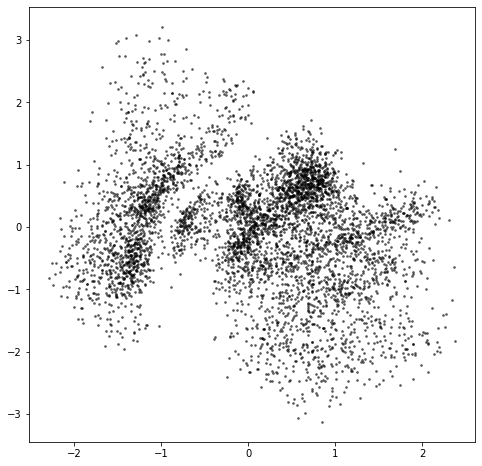

In [23]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

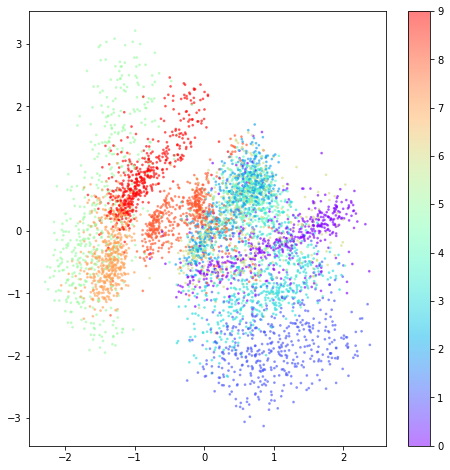

In [24]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c= example_labels, alpha=0.5, s=3)
plt.colorbar()
plt.show()

In [30]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 [==============================] - 0s 19ms/step


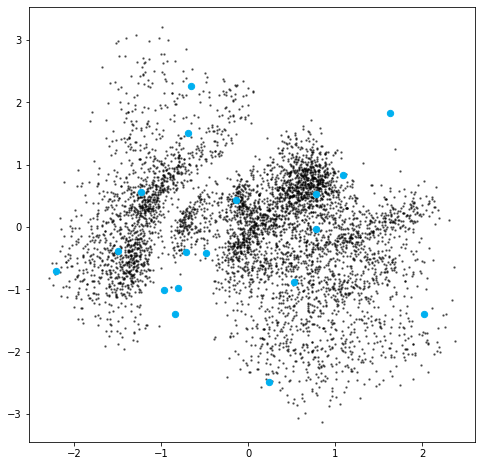

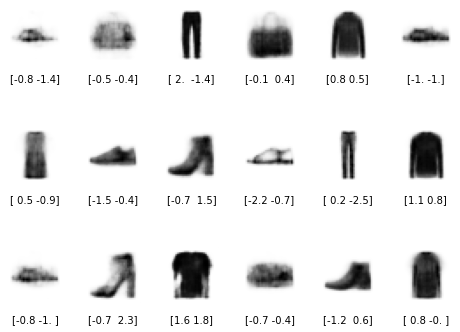

In [31]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

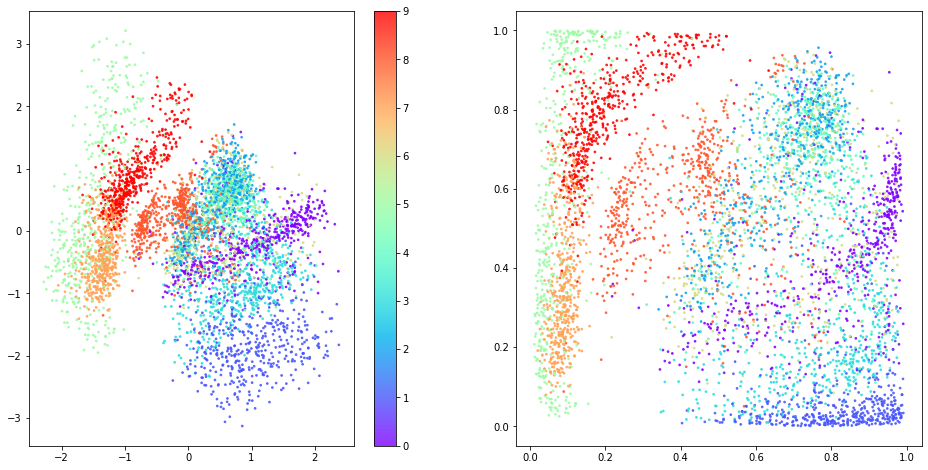

In [32]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()